# Код для повторения на Kaggle

Локально не тянет =)

In [1]:
%pip install pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from collections import defaultdict
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, random_split

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")


set_seed(42)

Random seed set as 42


In [4]:
class MetricTracker:
    def __init__(self):
        self.metrics = defaultdict(list)

    def update(self, metrics):
        for key, value in metrics.items():
            self.metrics[key].append(value)

In [5]:
class MetricsCallback(pl.Callback):
    def __init__(self, tracker):
        self.tracker = tracker

    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        self.tracker.update(
            {
                "train_loss": metrics["train_loss"].item(),
                "train_acc": metrics["train_acc"].item(),
                "val_loss": metrics["val_loss"].item(),
                "val_acc": metrics["val_acc"].item(),
            }
        )

In [6]:
means = (0.5071, 0.4867, 0.4408)
stds = (0.2675, 0.2565, 0.2761)

transform_train = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds),
    ]
)

In [7]:
def prepare_data():
    trainset = torchvision.datasets.CIFAR100(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR100(
        root="./data", train=False, download=True, transform=transform_test
    )

    train_size = int(0.8 * len(trainset))
    val_size = len(trainset) - train_size
    trainset, valset = random_split(trainset, [train_size, val_size])

    return trainset, valset, testset

In [8]:
class CIFAR100DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=128):
        super().__init__()
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.trainset, self.valset, self.testset = prepare_data()

    def train_dataloader(self):
        return DataLoader(
            self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(
            self.valset, batch_size=self.batch_size, shuffle=False, num_workers=4
        )

    def test_dataloader(self):
        return DataLoader(
            self.testset, batch_size=self.batch_size, shuffle=False, num_workers=4
        )

In [9]:
class AlexNet(pl.LightningModule):
    def __init__(self, num_classes=100):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss)
        self.log("val_acc", acc)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("test_loss", loss)
        self.log("test_acc", acc)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.1, patience=5, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

In [10]:
def evaluate_per_class(model, test_loader, num_classes=100):
    model.eval()
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    class_accuracy = {}
    for i in range(num_classes):
        if class_total[i] > 0:
            accuracy = class_correct[i] / class_total[i]
            class_accuracy[i] = accuracy

    return class_accuracy

In [11]:
tracker = MetricTracker()

data_module = CIFAR100DataModule()
data_module.setup()

model = AlexNet()

100%|██████████| 169M/169M [00:02<00:00, 59.6MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="./checkpoints",
    filename="alexnet-cifar100-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)

metrics_callback = MetricsCallback(tracker)

In [13]:
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices=1,
    callbacks=[checkpoint_callback, metrics_callback],
    log_every_n_steps=50,
)

In [14]:
trainer.fit(model, data_module)

Files already downloaded and verified
Files already downloaded and verified


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

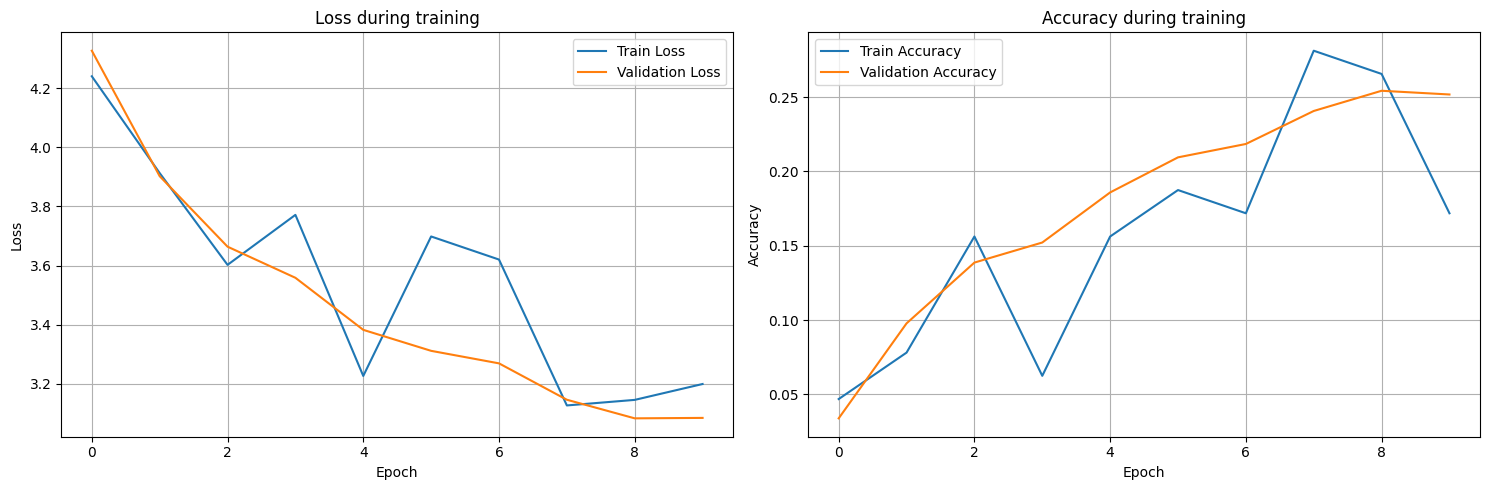

In [15]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(tracker.metrics["train_loss"], label="Train Loss")
plt.plot(tracker.metrics["val_loss"], label="Validation Loss")
plt.title("Loss during training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(tracker.metrics["train_acc"], label="Train Accuracy")
plt.plot(tracker.metrics["val_acc"], label="Validation Accuracy")
plt.title("Accuracy during training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

In [16]:
test_results = trainer.test(model, datamodule=data_module)

Files already downloaded and verified
Files already downloaded and verified


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.27239999175071716    │
│         test_loss         │     2.995232343673706     │
└───────────────────────────┴───────────────────────────┘

In [17]:
print(f"Train Loss: {tracker.metrics['train_loss'][-1]:.4f}")
print(f"Validation Loss: {tracker.metrics['val_loss'][-1]:.4f}")
print(f"Train Accuracy: {tracker.metrics['train_acc'][-1]:.4f}")
print(f"Validation Accuracy: {tracker.metrics['val_acc'][-1]:.4f}")

Train Loss: 3.1992
Validation Loss: 3.0846
Train Accuracy: 0.1719
Validation Accuracy: 0.2518


In [18]:
print(f"Test Loss: {test_results[0]['test_loss']:.4f}")
print(f"Test Accuracy: {test_results[0]['test_acc']:.4f}")

Test Loss: 2.9952
Test Accuracy: 0.2724
